# Forecasting USD Cash Inflow

In [5]:
# functionality
import numpy as np
import pandas as pd
import holidays

# plotting and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter

# ggplot utilities
from plotnine import (ggplot, geom_line, xlab, ylab, ggtitle, aes, theme, xlim, ylim, geom_boxplot,
                     geom_density, geom_histogram, after_stat, geom_ribbon, geom_smooth, geom_violin,
                     facet_wrap, facet_grid,  geom_point, scale_color_manual, scale_alpha_manual)

# interactive visualizations
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from itables import show
import plotly.express as px

# helper tools
from visualization import plot_time_series
from forex_python.converter import CurrencyRates

# setting some options for visualization
pd.options.display.float_format = '${:,.2f}'.format

plt.style.use('Solarize_Light2')

In [6]:
usd_cash_inflow_df = pd.read_excel("../data/raw/cash_data.xlsx")

# transform the column names to a more computer format
usd_cash_inflow_df.columns = [x.replace(" ", "_") for x in usd_cash_inflow_df.columns.str.lower()]


usd_cash_inflow_df
# filter only usd
usd_mask = usd_cash_inflow_df["currency"] == "USD"
usd_cash_inflow_df = usd_cash_inflow_df[usd_mask][["date", "cash_inflow"]]

usd_cash_inflow_df = (usd_cash_inflow_df
 .assign(date=pd.to_datetime(usd_cash_inflow_df["date"]))
 .assign(
    year=lambda df: df["date"].dt.year,
    month=lambda df: df["date"].dt.month,
    week=lambda df: df["date"].dt.week,
    day=lambda df: df["date"].dt.day,
    weekday=lambda df: df["date"].dt.weekday + 1,
 )
)
show(usd_cash_inflow_df)

C:\Users\Nikola_Shahpazov\AppData\Local\Temp\ipykernel_16024\1892432679.py:17: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [7]:
# Using plotly.express
fig = px.line(usd_cash_inflow_df, x='date', y="cash_inflow", title='USD Cash Inflow')
fig.show()

### Explore Seasonality

##### Weekly Seasonality

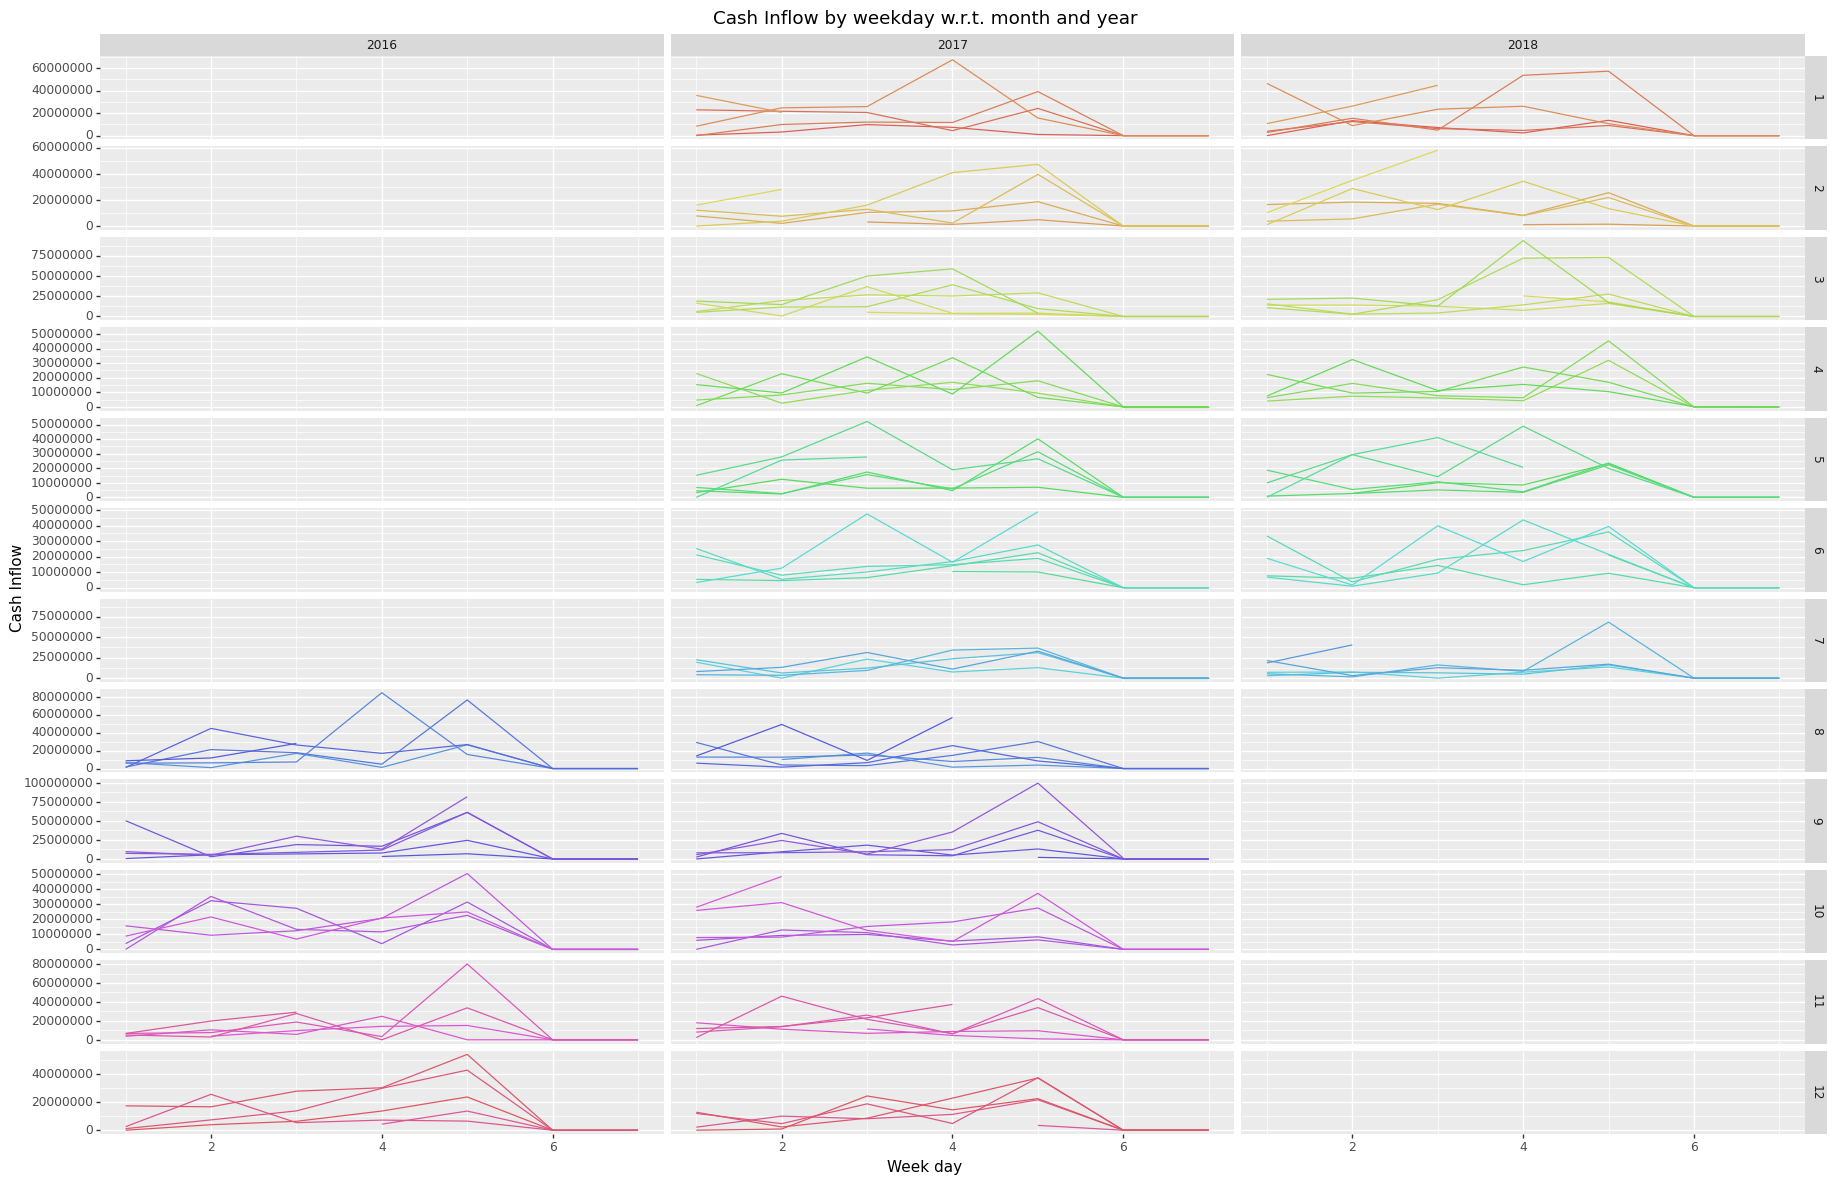

<ggplot: (145252144415)>

In [8]:
(usd_cash_inflow_df
 .assign(week=lambda df: pd.Categorical(df["week"]))
 .pipe(ggplot) +
    aes(x="weekday", y="cash_inflow", color="week") +
    geom_line() +
    xlab("Week day") +
    ylab("Cash Inflow") +
    facet_grid("month ~ year", scales="free") +
    theme(figure_size=(22, 14), legend_position="none") +
    ggtitle("Cash Inflow by weekday w.r.t. month and year")
)

We can see far more cash inflow by the end of the working week and as expected, no inflow in the weekends. `is_weekend` would be a great indicator for whether there would be no inflow. `weekday` would might also show good results. Lets explore it futher by distribution on different days.

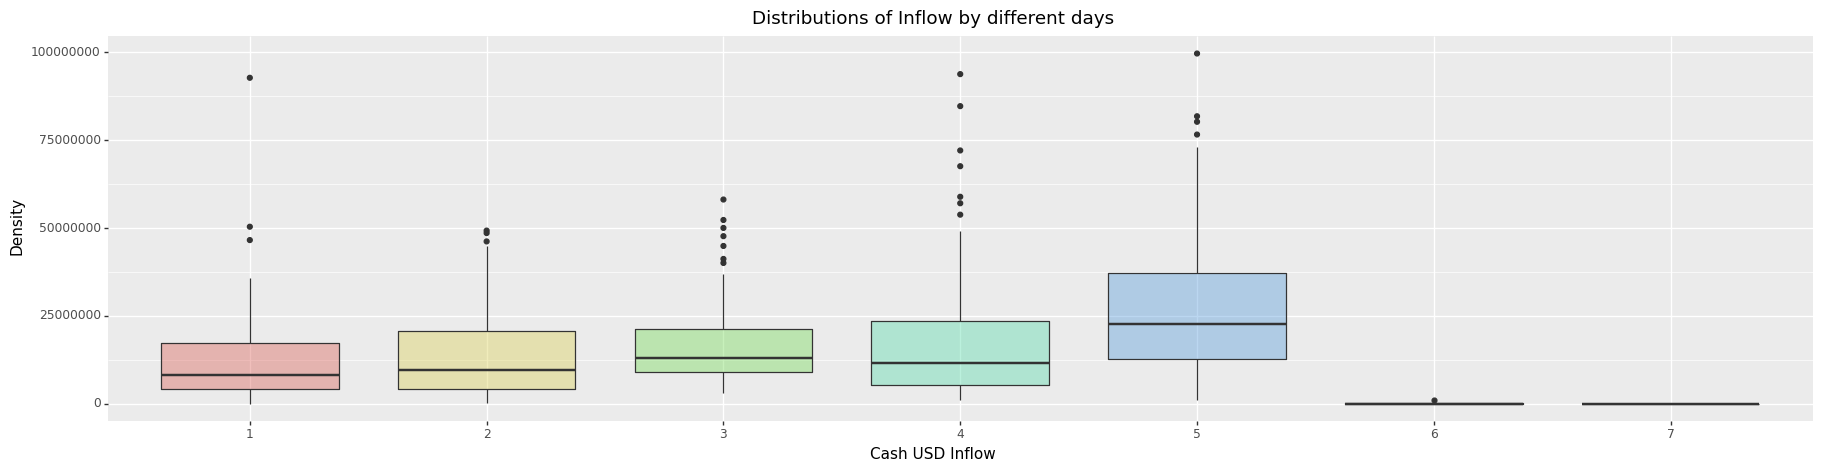

<ggplot: (145252098901)>

In [9]:
(usd_cash_inflow_df
 [usd_cash_inflow_df.cash_inflow != 0]
 .assign(
    month=lambda df: pd.Categorical(df.month),
    weekday=lambda df: pd.Categorical(df.weekday)
)
 .pipe(ggplot) +
    aes(x="weekday", y="cash_inflow", fill="weekday") +
    geom_boxplot(alpha=0.4) +
    xlab("Cash USD Inflow") +
    ylab("Density") +
    ggtitle("Distributions of Inflow by different days") +
    # facet_grid("year ~ month") +
    theme(legend_position="none", figure_size=(22, 5))
)

This further shows that Friday gives a significant boost in the inflow, while in the rest of the days the inflow stays pretty much the same.

### What about by different weeks

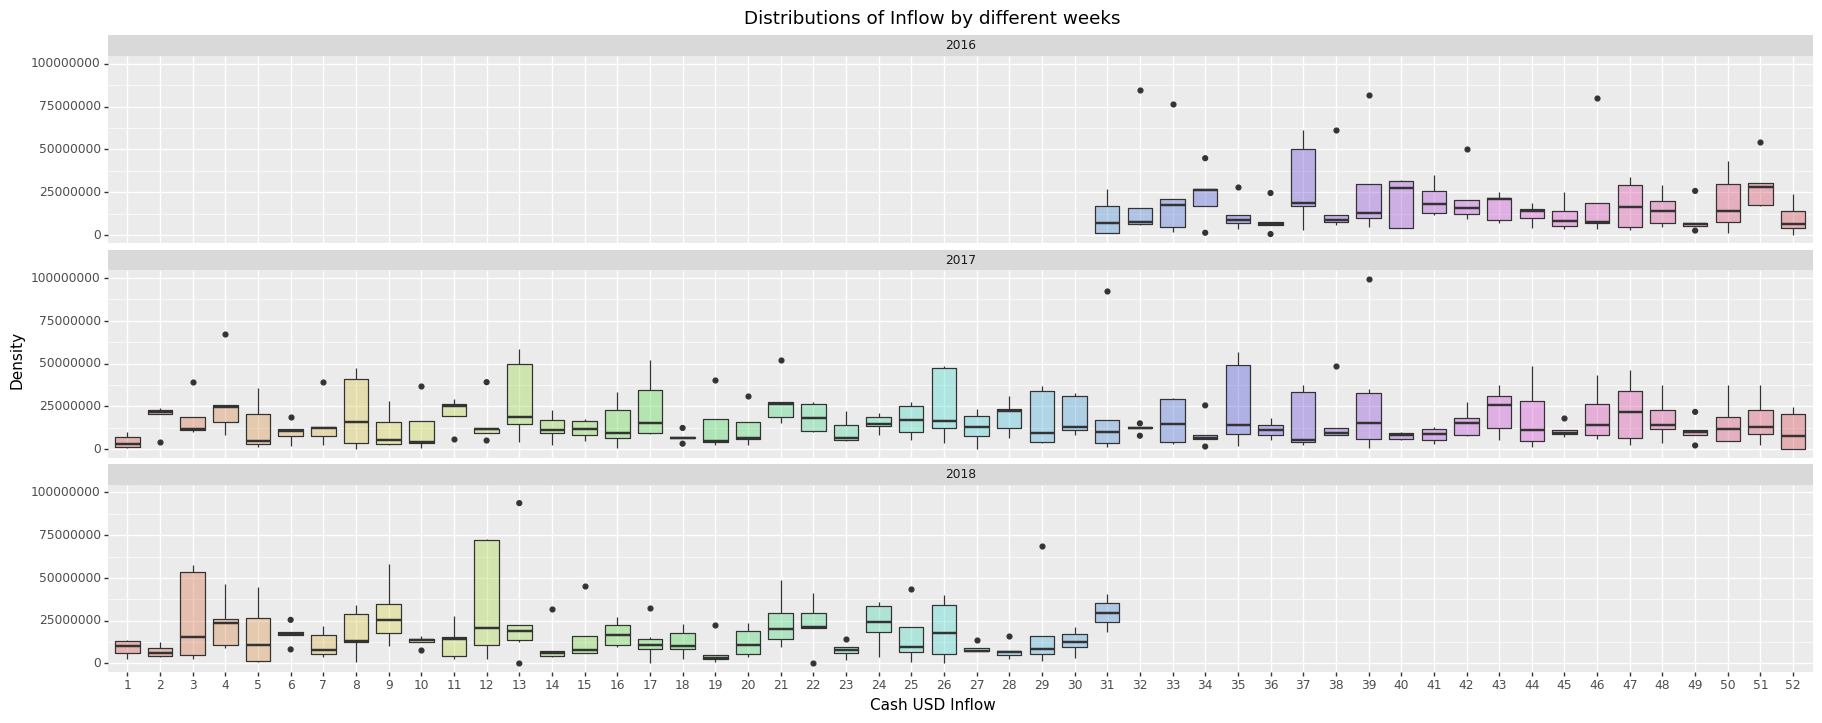

<ggplot: (145255810422)>

In [10]:
(usd_cash_inflow_df
 [usd_cash_inflow_df.cash_inflow != 0]
 .assign(
    month=lambda df: pd.Categorical(df.month),
    week=lambda df: pd.Categorical(df.week),
    weekday=lambda df: pd.Categorical(df.weekday)
)
 .pipe(ggplot) +
    aes(x="week", y="cash_inflow", fill="week") +
    geom_boxplot(alpha=0.4) +
    xlab("Cash USD Inflow") +
    ylab("Density") +
    ggtitle("Distributions of Inflow by different weeks") +
    facet_wrap("year", ncol=1) +
    theme(legend_position="none", figure_size=(22, 8))
)

We can see that the inflow varies significantly by the different weeks of the years. The week might be a good feature for forecasting the future inflow.

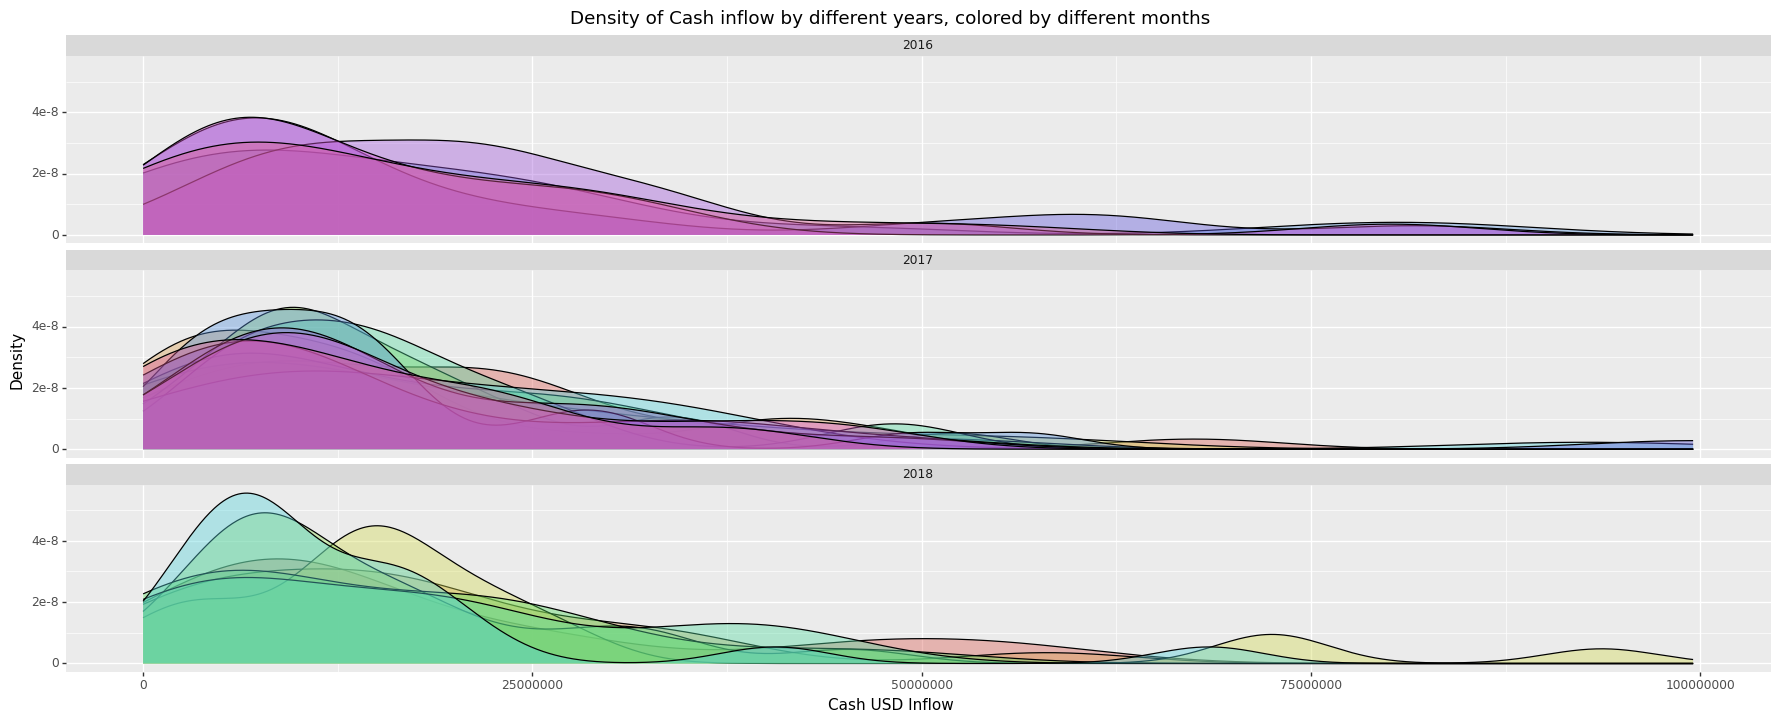

<ggplot: (145256718761)>

In [11]:
(usd_cash_inflow_df
 [usd_cash_inflow_df.cash_inflow != 0]
 .assign(month=lambda df: pd.Categorical(df.month))
 .pipe(ggplot) +
    aes(x="cash_inflow", fill="month") +
    geom_density(alpha=0.4) +
    xlab("Cash USD Inflow") +
    ylab("Density") +
    ggtitle("Density of Cash inflow by different years, colored by different months") +
    facet_wrap("year", ncol=1) +
    theme(legend_position="none", figure_size=(22, 8))
)

We can see that appart from some big inflows of cash in 2016 and 2018, the inflow distribution lies between **$0** and **$50,000,000**.

In [12]:
us_holidays = holidays.US()

is_holiday = usd_cash_inflow_df.date.apply(lambda x: x in us_holidays)
usd_cash_inflow_df["is_holiday"] = is_holiday

In [13]:
(usd_cash_inflow_df[is_holiday].cash_inflow == 0).mean().round(3)

0.565

In 56% of the cases when it's a holiday, there hasn't been any cash inflow.